In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import solve_triangular
from sklearn.linear_model import Ridge

### Problem 1

Derive/show how to compute linear regression coefficients (for general choice of y and X) using the following four methods: naive linear algebra; QR decomposition; SVD; and Cholesky decomposition.

Optionally, look up the computational (time) complexity of each of these methods as a function of $p$ (number of predictors/columns of X) and $n$ (number of observations/length of y/rows of X)

Pick three of the four algorithms and implement them in the language of your choice. Benchmark your algorithms for a range of magnitudes of $p$ and $n$ covering at least one order of magnitude in $p$ and at least two orders of magnitude in $n$.  Plot your results on a log-log scale. Fit a log-log model to the average times (you can leave out some points if they mess up the scaling relationship).

1. Naive linear algebra

The residual sum-of-squares can be written as

$$
\begin{align}
\text{RSS}(\beta) &= (\mathbf{y}-\mathbf{X}\beta)^T(\mathbf{y}-\mathbf{X}\beta) \\
&= (\mathbf{y}^T-\beta^T\mathbf{X}^T)(\mathbf{y}-\mathbf{X}\beta) \\
&= \mathbf{y}^T\mathbf{y}-\mathbf{y}^T\mathbf{X}\beta - \beta^T\mathbf{X}^T\mathbf{y} + \beta^T\mathbf{X}^T\mathbf{X}\beta \\
&= \mathbf{y}^T\mathbf{y}-2\beta^T\mathbf{X}^T\mathbf{y} + \beta^T\mathbf{X}^T\mathbf{X}\beta
\end{align}
$$

where the last equality is due to the special case that $\mathbf{y}$ and $\beta$ are vectors, such that $\mathbf{y}^T\mathbf{X}\beta$ and $\beta^T\mathbf{X}^T\mathbf{y}$ are scalars and therefore symmetric.

Differentiating w.r.t. $\beta$:

$$
\begin{align}
\frac{\partial \text{RSS}}{\partial \beta} &= -2\mathbf{X}^T\mathbf{y} + 2\mathbf{X}^T\mathbf{X}\beta\\
&= -2\mathbf{X}^T(\mathbf{y}-\mathbf{X}\beta)
\end{align}
$$

Setting the derivative to zero gives 

$$
\begin{align}
\mathbf{X}^T(\mathbf{y}-\mathbf{X}\beta)&=0\\
\mathbf{X}^T\mathbf{X}\beta &= \mathbf{X}^T\mathbf{y} \\
\beta &= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
\end{align}$$


Resources:   
http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf  
https://math.stackexchange.com/questions/2753210/when-can-we-say-that-a-mathrm-t-b-b-mathrm-t-a

In [9]:
def ls_naive(X,y):
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)

2. QR decomposition

Given the factorization $\mathbf{X}=\mathbf{Q}\mathbf{R}$ where $\mathbf{Q}$ is an orthogonal matrix ($\mathbf{Q}^T\mathbf{Q}=\mathbf{I}$) and $\mathbf{R}$ is an upper triangular matrix, the equation for $\beta$ simplifies to:

$$
\begin{align}
\beta &= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} \\
&= (\mathbf{R}^T\mathbf{Q}^T\mathbf{Q}\mathbf{R})^{-1}\mathbf{R}^T\mathbf{Q}^T\mathbf{y} \\
&= (\mathbf{R}^T\mathbf{R})^{-1}\mathbf{R}^T\mathbf{Q}^T\mathbf{y} \\
&= \mathbf{R}^{-1}\mathbf{Q}^T\mathbf{y}
\end{align}
$$

As $\mathbf{R}$ is an upper triangular matrix, the equation 

$$\mathbf{R}\beta=\mathbf{Q}^T\mathbf{y}$$

can be solved by back substitution.

QR decomposition can be computed using e.g. the Gram-Schmidt method

Resources:  
For realizing that $\beta = \mathbf{R}^{-1}\mathbf{Q}^T\mathbf{y}$ should be re-arranged to $\mathbf{R}\beta=\mathbf{Q}^T\mathbf{y}$ and solved using backward substitution: https://stats.stackexchange.com/questions/160007/understanding-qr-decomposition  
Implementation of Gram-Schmidt for QR decomposition: https://en.wikipedia.org/wiki/QR_decomposition

In [10]:
def GramSchmidt_QR(X):
    U = np.zeros(X.shape)
    U[:,0] = X[:,0]
    for col_i in range(1,X.shape[1]):
        a_i = X[:,col_i]
        U[:,col_i] = a_i 
        for i in range(col_i):
            u = U[:,i]
            U[:,col_i] -= np.dot(u, a_i)/np.dot(u,u) * u
    Q = np.divide(U, np.linalg.norm(U, axis=0))
    R = np.matmul(Q.T, X)
    return Q, R

def ls_QR(X,y):
#     Q, R = GramSchmidt_QR(X)
    Q, R = np.linalg.qr(X)
    beta = solve_triangular(R, np.matmul(Q.T, y))
    return beta

3. SVD

SVD can be used to decompose $\mathbf{X}$ into the product of $\mathbf{U}\mathbf{S}\mathbf{V}^T$ where $\mathbf{U}$ and $\mathbf{V}$ are unitary matrices. The equation for $\beta$ can then be simplified:

$$
\begin{align}
\beta &= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} \\
&= (\mathbf{V}\mathbf{S}^T\mathbf{U}^T\mathbf{U}\mathbf{S}\mathbf{V}^T)^{-1}\mathbf{V}\mathbf{S}^T\mathbf{U}^T\mathbf{y}\\
&= (\mathbf{V}\mathbf{S}^T\mathbf{S}\mathbf{V}^T)^{-1}\mathbf{V}\mathbf{S}^T\mathbf{U}^T\mathbf{y} \\
&= \mathbf{V}\mathbf{S}^{-1}(\mathbf{S}^T)^{-1}\mathbf{V}^T\mathbf{V}\mathbf{S}^T\mathbf{U}^T\mathbf{y} \\
&= \mathbf{V}\mathbf{S}^{-1}\mathbf{U}^T\mathbf{y}
\end{align}
$$


Resources used:  
https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse

In [11]:
def ls_SVD(X,y):
    u, s, vh = np.linalg.svd(X)
    s_pseudoinv = np.zeros([u.shape[1],vh.shape[0]])
    s_pseudoinv[:len(s),:len(s)] = np.diag(1/s)
    s_pseudoinv = s_pseudoinv.T
    X_pseudoinv = np.matmul(np.matmul(vh.T, s_pseudoinv),u.T)
    
    return np.matmul(X_pseudoinv,y)

4. Cholesky decomposition

Alternatively, we can solve $\mathbf{X}^T\mathbf{X} \beta = \mathbf{X}^T\mathbf{y}$ by applying a Cholesky decomposition to $\mathbf{X}^T\mathbf{X}$, i.e. $\mathbf{X}^T\mathbf{X}=\mathbf{L}\mathbf{L}^T$, where $\mathbf{L}$ is lower triangular. We solve for $\beta$ by first solving  
  
$$\mathbf{L}\mathbf{b} = \mathbf{X}^T\mathbf{y}$$

by forward substitution, then 

$$\mathbf{L}^T\beta = \mathbf{b} $$

by backward substitution

Resources used:  
https://en.wikipedia.org/wiki/Cholesky_decomposition  
https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html

In [12]:
def ls_cholesky(X,y):
    L = np.linalg.cholesky(np.matmul(X.T, X))
    b1 = solve_triangular(L, np.matmul(X.T,y), lower=True)
    beta = solve_triangular(L.T, b1)
    return beta

Run time analysis:

Somehow the naive linear algebra is faster than the QR decomposition and SVD methods (not shown because it crashed the kernel for some of the test cases). Not sure what I am doing wrong. 

In [13]:
def generate_data(n, p):
    means = np.random.normal(loc=0, scale=10, size=p)
    stds = np.abs(np.random.normal(loc=5, scale=1, size=p))
    betas = np.random.normal(loc=0, scale=20, size=p+1)
    X = np.ones([n, p+1])
    for i in range(p):
        X[:,i] = np.random.normal(loc=means[i], scale=stds[i], size=n)
    y = np.matmul(X, betas) 
    y += np.random.normal(loc=0, scale=2, size=y.shape)
    return X, y

In [14]:
n = np.logspace(3, 6, 4, dtype=int)
naive_times = np.zeros([len(n),2])
QR_times = np.zeros([len(n),2])
SVD_times = np.zeros([len(n),2])
cholesky_times = np.zeros([len(n),2])

for i in range(len(n)):
    X, Y = generate_data(n[i], 10)
    naive = %timeit -o ls_naive(X, Y)
    naive_times[i] = [np.mean(naive.timings), np.std(naive.timings)]
    QR = %timeit -o ls_QR(X, Y)
    QR_times[i] = [np.mean(QR.timings), np.std(QR.timings)]
#     SVD = %timeit -o ls_SVD(X, Y)
#     SVD_times[i] = [np.mean(SVD.timings), np.std(SVD.timings)]
    cholesky = %timeit -o ls_cholesky(X, Y)
    cholesky_times[i] = [np.mean(cholesky.timings), np.std(cholesky.timings)]

52.6 µs ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
145 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
41.7 µs ± 395 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
370 µs ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.36 ms ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
245 µs ± 271 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.24 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.8 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.39 ms ± 8.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.8 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
246 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
23.4 ms ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


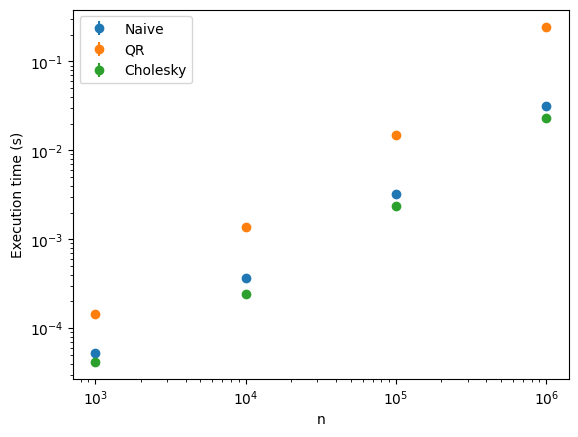

In [21]:
plt.errorbar(n, naive_times[:,0], yerr=naive_times[:,1], fmt='o', label="Naive")
plt.errorbar(n, QR_times[:,0], yerr=QR_times[:,1], fmt='o', label="QR")
plt.errorbar(n, cholesky_times[:,0], yerr=cholesky_times[:,1], fmt='o', label="Cholesky")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n")
plt.ylabel("Execution time (s)")
plt.legend(loc="best")
plt.show()

In [22]:
p = np.logspace(1, 3, 5, dtype=int)
naive_times_p = np.zeros([len(p),2])
QR_times_p = np.zeros([len(p),2])
cholesky_times_p = np.zeros([len(p),2])

for i in range(len(p)):
    X, Y = generate_data(10000, p[i])
    naive = %timeit -o ls_naive(X, Y)
    naive_times_p[i] = [np.mean(naive.timings), np.std(naive.timings)]
    QR = %timeit -o ls_QR(X, Y)
    QR_times_p[i] = [np.mean(QR.timings), np.std(QR.timings)]
#     SVD = %timeit -o ls_SVD(X, Y)
#     SVD_times[i] = [np.mean(SVD.timings), np.std(SVD.timings)]
    cholesky = %timeit -o ls_cholesky(X, Y)
    cholesky_times_p[i] = [np.mean(cholesky.timings), np.std(cholesky.timings)]

451 µs ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.34 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
245 µs ± 452 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.44 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
10 ms ± 723 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
873 µs ± 35 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.57 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
44.8 ms ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.32 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.3 ms ± 5.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
188 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.1 ms ± 410 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
273 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.07 s ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
132 ms ± 8.04

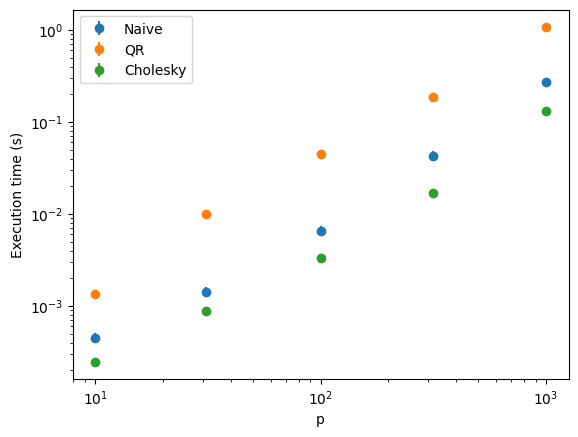

In [23]:
plt.errorbar(p, naive_times_p[:,0], yerr=naive_times_p[:,1], fmt='o', label="Naive")
plt.errorbar(p, QR_times_p[:,0], yerr=QR_times_p[:,1], fmt='o', label="QR")
plt.errorbar(p, cholesky_times_p[:,0], yerr=cholesky_times_p[:,1], fmt='o', label="Cholesky")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("p")
plt.ylabel("Execution time (s)")
plt.legend(loc="best")
plt.show()

### Problem 2

Implement ridge regression by data augmentation in the language of your choice.  Compare results and timing with a native implementation of ridge regression.

1. Data augmentation

From the notes, using the augmented data matrix

$$\mathbf{B} = \left[ {\begin{array}{c} \mathbf{X} \\ \sqrt{\lambda}\mathbf{I}\end{array} } \right]$$

and augmented observations $\mathbf{y}^* = (\mathbf{y} \hspace{1em} 0)$, we have

$$(\mathbf{B}^T\mathbf{B})\beta = \mathbf{B}^T\mathbf{y}^*$$

Applying QR decomposition: $\mathbf{B}=\mathbf{Q}\mathbf{R}$

$$
\begin{align}
(\mathbf{R}^T\mathbf{Q}^T\mathbf{Q}\mathbf{R})\beta &= \mathbf{R}^T\mathbf{Q}^T\mathbf{y}^* \\
\mathbf{R}^T\mathbf{R}\beta &= \mathbf{R}^T\mathbf{Q}^T\mathbf{y}^*
\end{align}
$$

which can be solved by first solving 

$$\mathbf{R}^T\mathbf{A} = \mathbf{R}^T\mathbf{Q}^T\mathbf{y}^*$$

then solving

$$\mathbf{R}\beta=\mathbf{A}$$

In [2]:
def ridge_augmentation(X,y,lamb):
    B = np.zeros([X.shape[0]+X.shape[1], X.shape[1]])
    B[:X.shape[0],:] = X
    B[X.shape[0]:,:] = np.diag(lamb**0.5 * np.ones(X.shape[1]))
    
    y_star = np.zeros(len(y)+X.shape[1])
    y_star[:len(y)] = y
    
    Q, R = np.linalg.qr(B)
    A = solve_triangular(R.T, np.matmul(np.matmul(R.T,Q.T),y_star), lower=True)
    beta = solve_triangular(R, A)
    return beta

In [14]:
def compute_RSS(X, y, beta):
    residuals = y - np.matmul(X,beta)
    return np.matmul(residuals.T, residuals)

def normalize_columns(A):
    """scale to have mean zero and variance 96 like in ESL"""
    A -= np.mean(A, axis=0)
    std = np.std(A, axis=0)
    A /= std
    A *= 96**0.5
    return A

In [5]:
prostate_data = pd.read_csv("prostate_cancer.txt", index_col=0, delimiter='\t')
prostate_data["train"].astype("category")
prostate_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [6]:
train_set = prostate_data[prostate_data["train"]=="T"]
test_set = prostate_data[prostate_data["train"]=="F"]

train_X = train_set[["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]].to_numpy()
train_X = normalize_columns(train_X)
train_Y = train_set["lpsa"].to_numpy()

test_X = test_set[["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]].to_numpy()
test_X = normalize_columns(test_X)
test_Y = test_set["lpsa"].to_numpy()

In order to prevent shrinking the intercept, we center $\mathbf{y}$ upfront by subtracting the mean of the training set from both the training and test labels. 

In [36]:
n = 20
lambdas = np.linspace(0, 10000, n)
intercept = np.mean(train_Y)

RSS_aug = np.zeros(n)
RSS_native = np.zeros(n)
for i in range(len(lambdas)):
    beta_aug = ridge_augmentation(train_X, train_Y-intercept, lambdas[i])
    RSS_aug[i] = compute_RSS(test_X, test_Y-intercept, beta_aug)
    
    ## native implementation using scikit-learn, automatically fits intercept
    clf = Ridge(alpha=lambdas[i])
    clf.fit(train_X, train_Y)
    y_hat = clf.predict(test_X)
    residuals = test_Y - y_hat
    RSS_native[i] = np.matmul(residuals.T, residuals)

Performance results:

The two approaches give essentially identical results. It is surprising to me that such a high value of $\lambda$ is optimal...

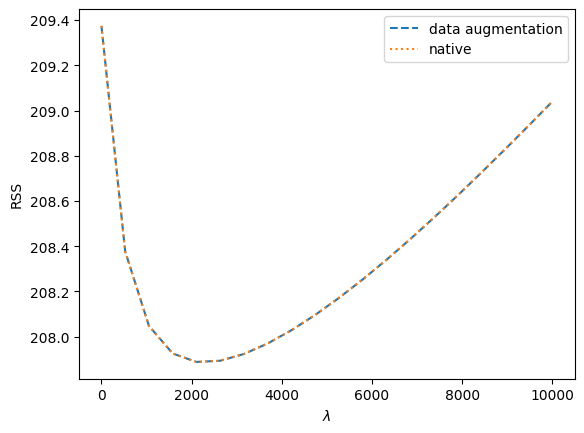

In [35]:
plt.plot(lambdas, RSS_aug, ls='dashed', label="data augmentation")
plt.plot(lambdas, RSS_native, ls='dotted', label="native")
plt.legend(loc='best')
plt.xlabel("$\lambda$")
plt.ylabel("RSS")
plt.show()

Timing comparison: 

Somehow the native implementation is slower. Maybe there is some overhead in the fit() method which I haven't isolated out of the timing loop. 

In [22]:
%timeit -r 10 ridge_augmentation(train_X, train_Y, 1)

32.6 µs ± 31.1 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [39]:
clf = Ridge(alpha=1)

In [38]:
%timeit -r 10 clf.fit(train_X, train_Y)

89.9 µs ± 712 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


I'm not taking the class for credit, and have not attempted the remainder of the problem set, but would really appreciate comments/feedback on the first two problems. 